/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)
/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


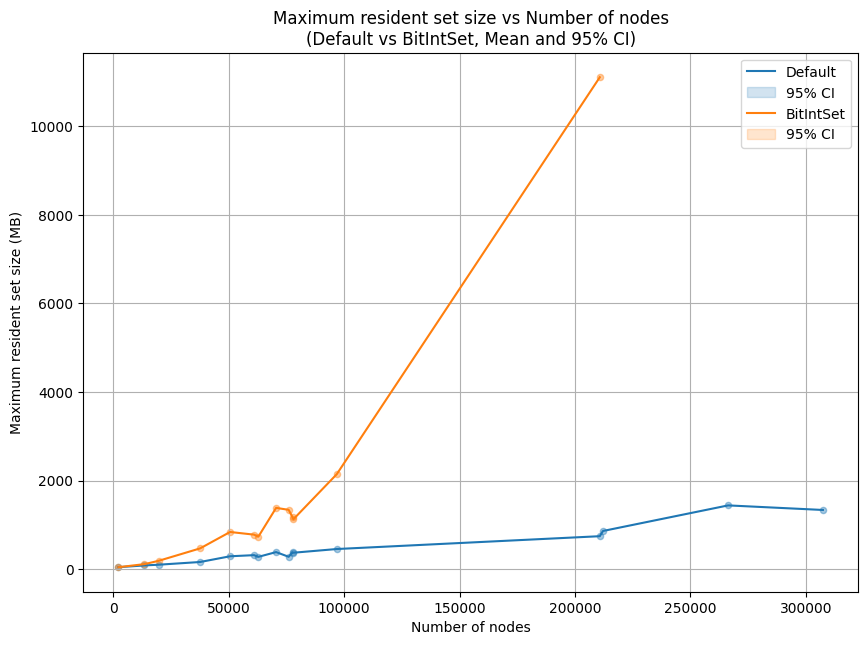

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, t

# Load both CSV files
df1 = pd.read_csv("experiment_results_build.csv")
df2 = pd.read_csv("experiment_results_build_BitIntSet.csv")

def prep_df(df):
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")
    df = df.sort_values("Number of nodes")
    means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
    counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
    sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB
    return means, conf95, df

means1, conf95_1, df1 = prep_df(df1)
means2, conf95_2, df2 = prep_df(df2)

plt.figure(figsize=(10, 7))
plt.plot(means1.index, means1.values, label="Default", color="tab:blue")
plt.fill_between(means1.index, means1.values - conf95_1, means1.values + conf95_1, color="tab:blue", alpha=0.2,label="95% CI")
plt.scatter(df1["Number of nodes"], df1["Maximum resident set size (kbytes)"] / 1024, color="tab:blue", alpha=0.4, s=20)

plt.plot(means2.index, means2.values, label="BitIntSet", color="tab:orange")
plt.fill_between(means2.index, means2.values - conf95_2, means2.values + conf95_2, color="tab:orange", alpha=0.2, label="95% CI")
plt.scatter(df2["Number of nodes"], df2["Maximum resident set size (kbytes)"] / 1024, color="tab:orange", alpha=0.4, s=20)

plt.xlabel("Number of nodes")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs Number of nodes\n(Default vs BitIntSet, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)
/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


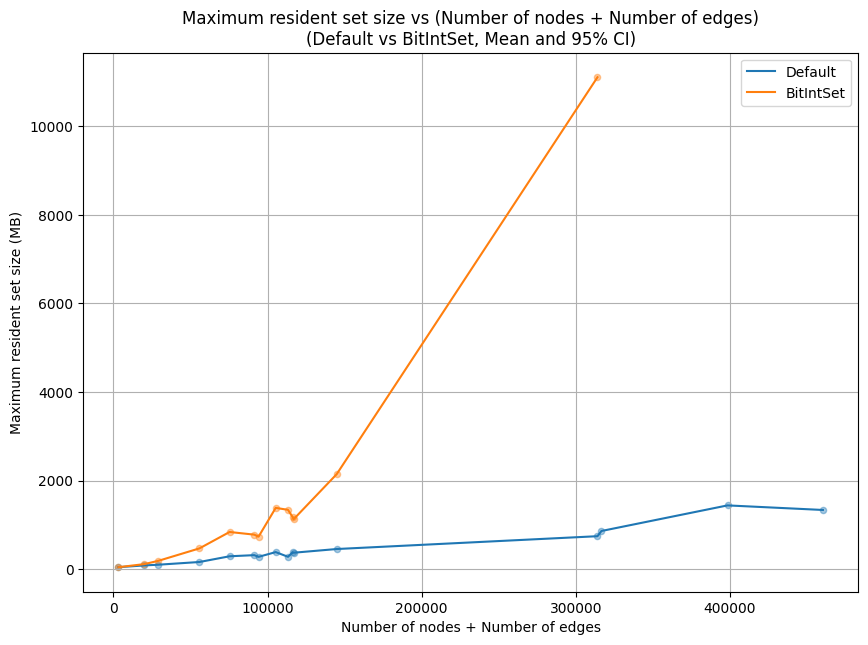

In [2]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_build.csv")
df2 = pd.read_csv("experiment_results_build_BitIntSet.csv")

def prep_df(df):
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["Number of edges"] = pd.to_numeric(df["Number of edges"], errors="coerce")
    df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")
    df["Nodes + Edges"] = df["Number of nodes"] + df["Number of edges"]
    df = df.sort_values("Nodes + Edges")
    means = df.groupby("Nodes + Edges")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
    counts = df.groupby("Nodes + Edges")["Maximum resident set size (kbytes)"].count()
    sems = df.groupby("Nodes + Edges")["Maximum resident set size (kbytes)"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB
    return means, conf95, df

means1, conf95_1, df1 = prep_df(df1)
means2, conf95_2, df2 = prep_df(df2)

plt.figure(figsize=(10, 7))
plt.plot(means1.index, means1.values, label="Default", color="tab:blue")
plt.fill_between(means1.index, means1.values - conf95_1, means1.values + conf95_1, color="tab:blue", alpha=0.2)
plt.scatter(df1["Nodes + Edges"], df1["Maximum resident set size (kbytes)"] / 1024, color="tab:blue", alpha=0.4, s=20)

plt.plot(means2.index, means2.values, label="BitIntSet", color="tab:orange")
plt.fill_between(means2.index, means2.values - conf95_2, means2.values + conf95_2, color="tab:orange", alpha=0.2)
plt.scatter(df2["Nodes + Edges"], df2["Maximum resident set size (kbytes)"] / 1024, color="tab:orange", alpha=0.4, s=20)

plt.xlabel("Number of nodes + Number of edges")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs (Number of nodes + Number of edges)\n(Default vs BitIntSet, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)
/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


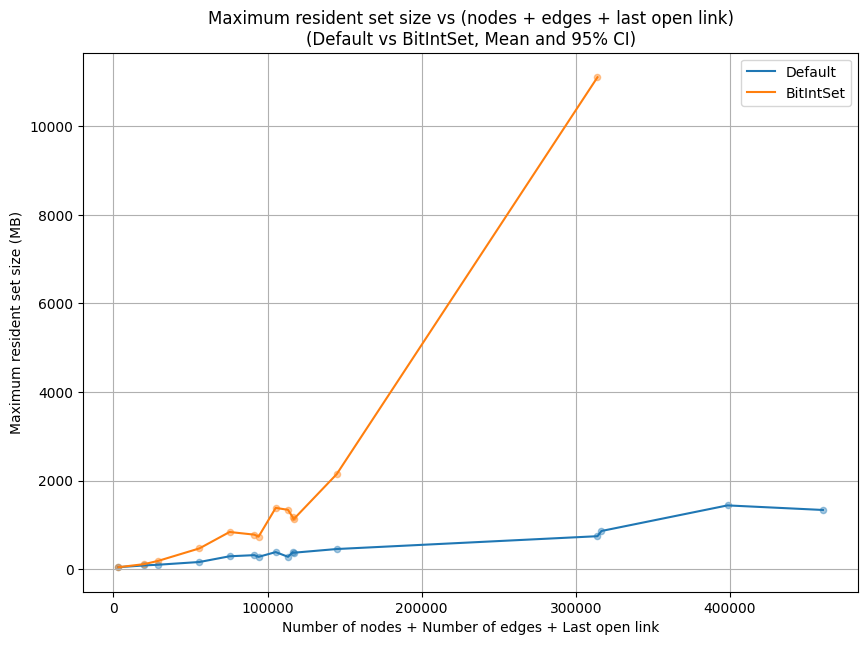

In [3]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_build.csv")
df2 = pd.read_csv("experiment_results_build_BitIntSet.csv")

def get_last_open_link(val):
    if pd.isna(val) or str(val).strip() == "":
        return 0
    try:
        return int(str(val).strip().split(";")[-1])
    except Exception:
        return 0

def prep_df(df):
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["Number of edges"] = pd.to_numeric(df["Number of edges"], errors="coerce")
    df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")
    df["Last open link"] = df["Number of open links"].apply(get_last_open_link)
    df["Nodes + Edges + LastOpenLink"] = df["Number of nodes"] + df["Number of edges"] + df["Last open link"]
    df = df.sort_values("Nodes + Edges + LastOpenLink")
    means = df.groupby("Nodes + Edges + LastOpenLink")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
    counts = df.groupby("Nodes + Edges + LastOpenLink")["Maximum resident set size (kbytes)"].count()
    sems = df.groupby("Nodes + Edges + LastOpenLink")["Maximum resident set size (kbytes)"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB
    return means, conf95, df

means1, conf95_1, df1 = prep_df(df1)
means2, conf95_2, df2 = prep_df(df2)

plt.figure(figsize=(10, 7))
plt.plot(means1.index, means1.values, label="Default", color="tab:blue")
plt.fill_between(means1.index, means1.values - conf95_1, means1.values + conf95_1, color="tab:blue", alpha=0.2)
plt.scatter(df1["Nodes + Edges + LastOpenLink"], df1["Maximum resident set size (kbytes)"] / 1024, color="tab:blue", alpha=0.4, s=20)

plt.plot(means2.index, means2.values, label="BitIntSet", color="tab:orange")
plt.fill_between(means2.index, means2.values - conf95_2, means2.values + conf95_2, color="tab:orange", alpha=0.2)
plt.scatter(df2["Nodes + Edges + LastOpenLink"], df2["Maximum resident set size (kbytes)"] / 1024, color="tab:orange", alpha=0.4, s=20)

plt.xlabel("Number of nodes + Number of edges + Last open link")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs (nodes + edges + last open link)\n(Default vs BitIntSet, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)
/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


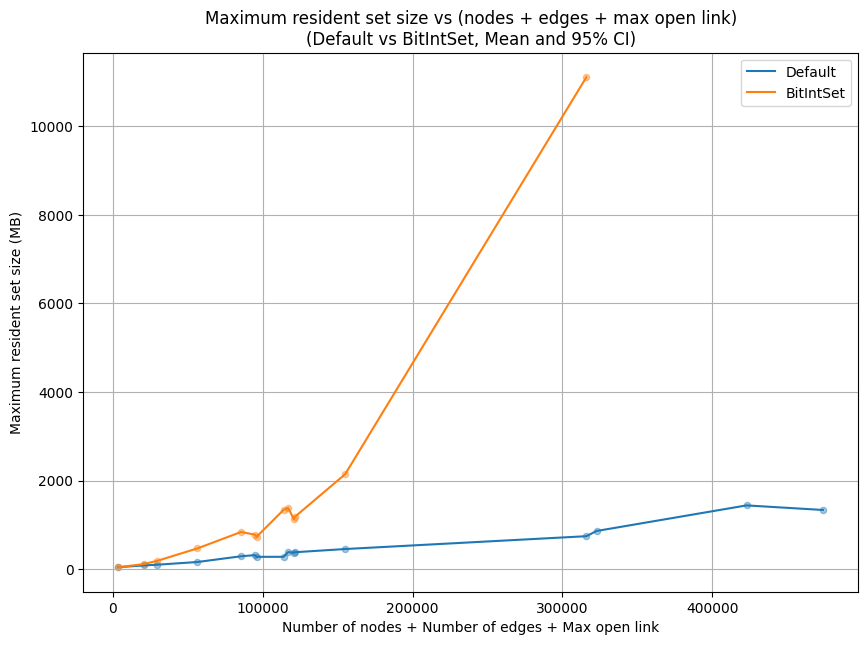

In [4]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_build.csv")
df2 = pd.read_csv("experiment_results_build_BitIntSet.csv")

def get_max_open_link(val):
    if pd.isna(val) or str(val).strip() == "":
        return 0
    try:
        return max(int(x) for x in str(val).strip().split(";") if x.strip() != "")
    except Exception:
        return 0

def prep_df(df):
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["Number of edges"] = pd.to_numeric(df["Number of edges"], errors="coerce")
    df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")
    df["Max open link"] = df["Number of open links"].apply(get_max_open_link)
    df["Nodes + Edges + MaxOpenLink"] = df["Number of nodes"] + df["Number of edges"] + df["Max open link"]
    df = df.sort_values("Nodes + Edges + MaxOpenLink")
    means = df.groupby("Nodes + Edges + MaxOpenLink")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
    counts = df.groupby("Nodes + Edges + MaxOpenLink")["Maximum resident set size (kbytes)"].count()
    sems = df.groupby("Nodes + Edges + MaxOpenLink")["Maximum resident set size (kbytes)"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB
    return means, conf95, df

means1, conf95_1, df1 = prep_df(df1)
means2, conf95_2, df2 = prep_df(df2)

plt.figure(figsize=(10, 7))
plt.plot(means1.index, means1.values, label="Default", color="tab:blue")
plt.fill_between(means1.index, means1.values - conf95_1, means1.values + conf95_1, color="tab:blue", alpha=0.2)
plt.scatter(df1["Nodes + Edges + MaxOpenLink"], df1["Maximum resident set size (kbytes)"] / 1024, color="tab:blue", alpha=0.4, s=20)

plt.plot(means2.index, means2.values, label="BitIntSet", color="tab:orange")
plt.fill_between(means2.index, means2.values - conf95_2, means2.values + conf95_2, color="tab:orange", alpha=0.2)
plt.scatter(df2["Nodes + Edges + MaxOpenLink"], df2["Maximum resident set size (kbytes)"] / 1024, color="tab:orange", alpha=0.4, s=20)

plt.xlabel("Number of nodes + Number of edges + Max open link")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs (nodes + edges + max open link)\n(Default vs BitIntSet, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


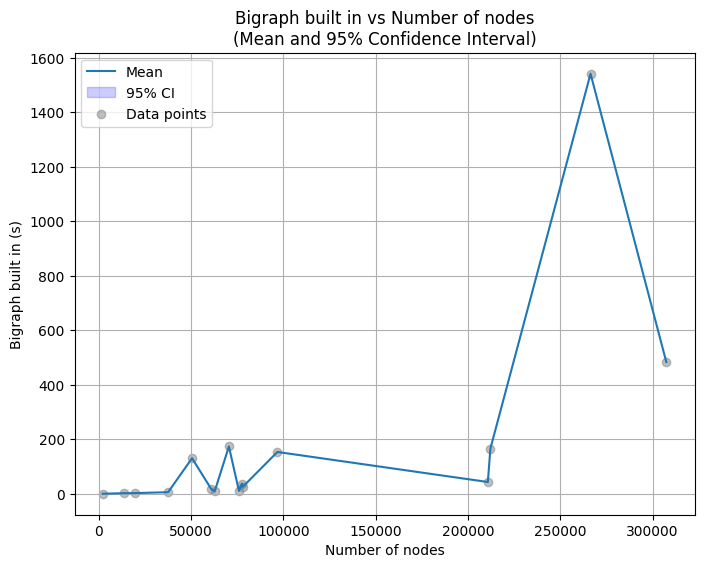

In [5]:
# Load CSV files
df = pd.read_csv("experiment_results_build.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Bigraph built in"] = pd.to_numeric(df["Bigraph built in"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Bigraph built in"].mean()
counts = df.groupby("Number of nodes")["Bigraph built in"].count()
sems = df.groupby("Number of nodes")["Bigraph built in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df["Number of nodes"], df["Bigraph built in"], color="gray", alpha=0.5, label="Data points")

plt.xlabel("Number of nodes")
plt.ylabel("Bigraph built in (s)")
plt.title("Bigraph built in vs Number of nodes\n(Mean and 95% Confidence Interval)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


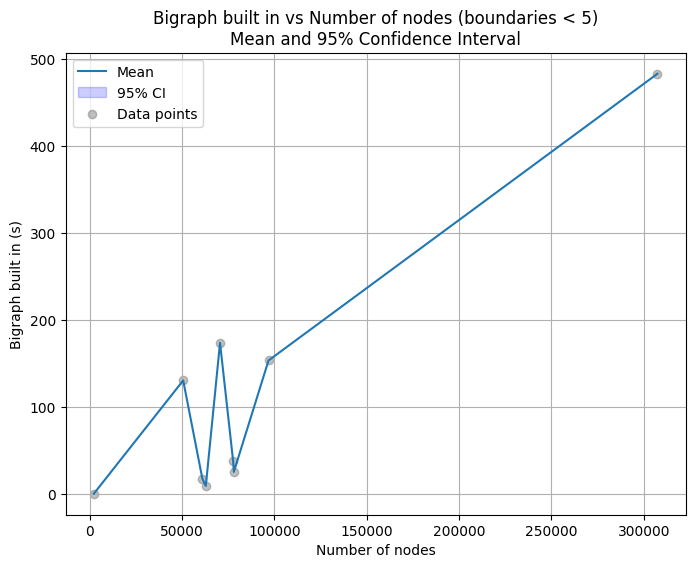

In [6]:
# Load CSV file
df = pd.read_csv("experiment_results_build.csv")

# Convert columns to numeric
df["Bigraph built in"] = pd.to_numeric(df["Bigraph built in"], errors="coerce")
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Number of boundaries"] = pd.to_numeric(df["Number of boundaries"], errors="coerce")

# Filter for boundaries < 5
df_filtered = df[df["Number of boundaries"] < 5]

# Group by Number of nodes and calculate mean and 95% CI
means = df_filtered.groupby("Number of nodes")["Bigraph built in"].mean()
counts = df_filtered.groupby("Number of nodes")["Bigraph built in"].count()
sems = df_filtered.groupby("Number of nodes")["Bigraph built in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df_filtered["Number of nodes"], df_filtered["Bigraph built in"], color="gray", alpha=0.5, label="Data points")

plt.xlabel("Number of nodes")
plt.ylabel("Bigraph built in (s)")
plt.title("Bigraph built in vs Number of nodes (boundaries < 5)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


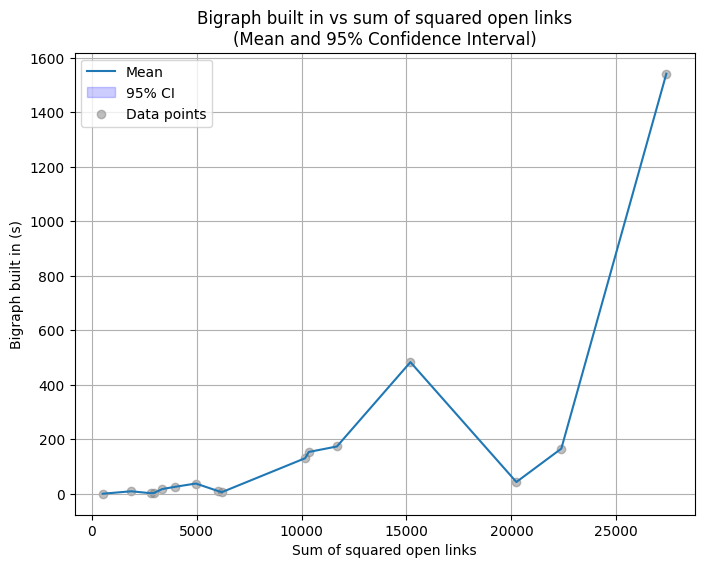

In [7]:
# Convert columns to numeric
df["Bigraph built in"] = pd.to_numeric(df["Bigraph built in"], errors="coerce")

# Extract the sum of squared open links from the "Number of open links" column
def sum_squared_open_links(val):
    if pd.isna(val) or str(val).strip() == "":
        return 0
    try:
        numbers = [int(x) for x in str(val).strip().split(";") if x.strip() != ""]
        return sum(x for x in numbers)
    except Exception:
        return 0

df["SumSquaredOpenLinks"] = df["Number of open links"].apply(sum_squared_open_links)

# Sort by sum of squared open links
df = df.sort_values("SumSquaredOpenLinks")

# Calculate mean and 95% confidence interval
means = df.groupby("SumSquaredOpenLinks")["Bigraph built in"].mean()
counts = df.groupby("SumSquaredOpenLinks")["Bigraph built in"].count()
sems = df.groupby("SumSquaredOpenLinks")["Bigraph built in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df["SumSquaredOpenLinks"], df["Bigraph built in"], color="gray", alpha=0.5, label="Data points")

plt.xlabel("Sum of squared open links")
plt.ylabel("Bigraph built in (s)")
plt.title("Bigraph built in vs sum of squared open links\n(Mean and 95% Confidence Interval)")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


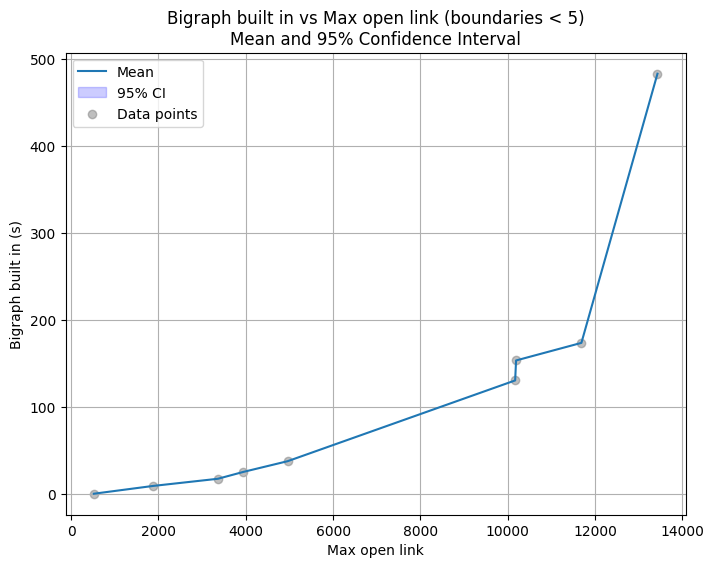

In [8]:
# Load CSV file
df = pd.read_csv("experiment_results_build.csv")

# Convert columns to numeric
df["Bigraph built in"] = pd.to_numeric(df["Bigraph built in"], errors="coerce")
df["Number of boundaries"] = pd.to_numeric(df["Number of boundaries"], errors="coerce")

# Extract max open link from "Number of open links"
def get_max_open_link(val):
    if pd.isna(val) or str(val).strip() == "":
        return 0
    try:
        return max(int(x) for x in str(val).strip().split(";") if x.strip() != "")
    except Exception:
        return 0

df["MaxOpenLink"] = df["Number of open links"].apply(get_max_open_link)

# Filter for boundaries < 5
df_filtered = df[df["Number of boundaries"] < 5]

# Group by MaxOpenLink and calculate mean and 95% CI
means = df_filtered.groupby("MaxOpenLink")["Bigraph built in"].mean()
counts = df_filtered.groupby("MaxOpenLink")["Bigraph built in"].count()
sems = df_filtered.groupby("MaxOpenLink")["Bigraph built in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df_filtered["MaxOpenLink"], df_filtered["Bigraph built in"], color="gray", alpha=0.5, label="Data points")

plt.xlabel("Max open link")
plt.ylabel("Bigraph built in (s)")
plt.title("Bigraph built in vs Max open link (boundaries < 5)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

# Load

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


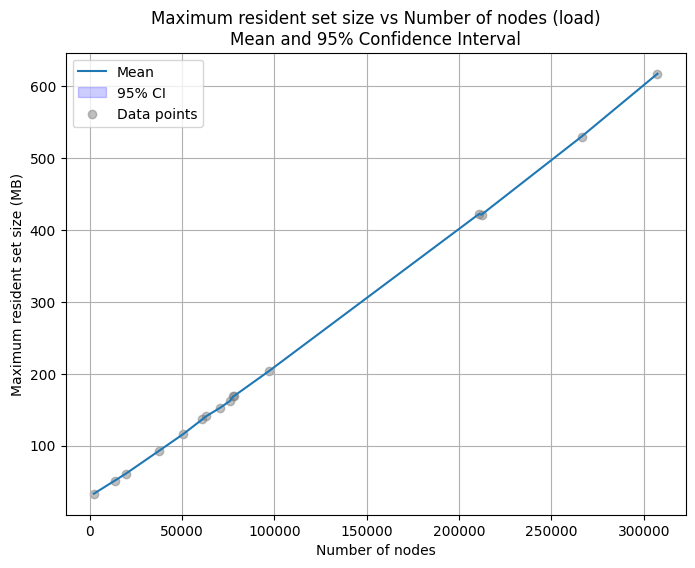

In [9]:
df = pd.read_csv("experiment_results_load.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df["Number of nodes"], df["Maximum resident set size (kbytes)"] / 1024, color="gray", alpha=0.5, label="Data points")

plt.xlabel("Number of nodes")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs Number of nodes (load)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

/home/roy/bigraph-of-the-world/.venv/lib/python3.12/site-packages/pandas/core/groupby/ops.py:919: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = f(group)


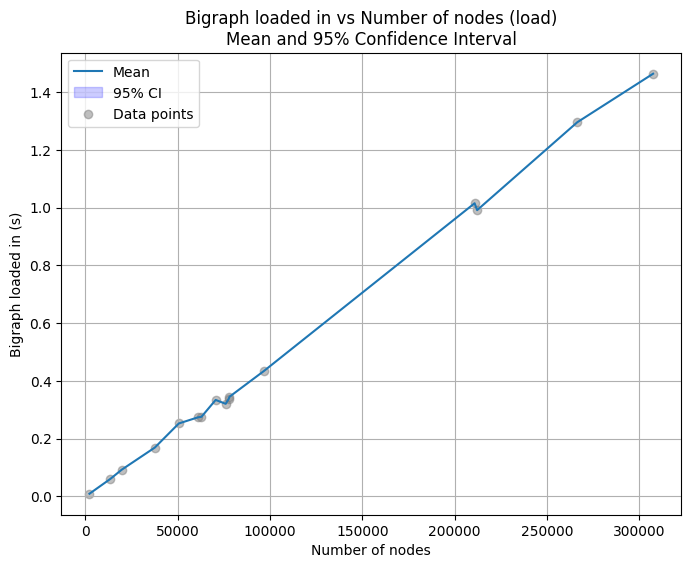

In [10]:
df = pd.read_csv("experiment_results_load.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Bigraph loaded in"] = pd.to_numeric(df["Bigraph loaded in"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Bigraph loaded in"].mean()
counts = df.groupby("Number of nodes")["Bigraph loaded in"].count()
sems = df.groupby("Number of nodes")["Bigraph loaded in"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1)

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df["Number of nodes"], df["Bigraph loaded in"], color="gray", alpha=0.5, label="Data points")

plt.xlabel("Number of nodes")
plt.ylabel("Bigraph loaded in (s)")
plt.title("Bigraph loaded in vs Number of nodes (load)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

# One reaction

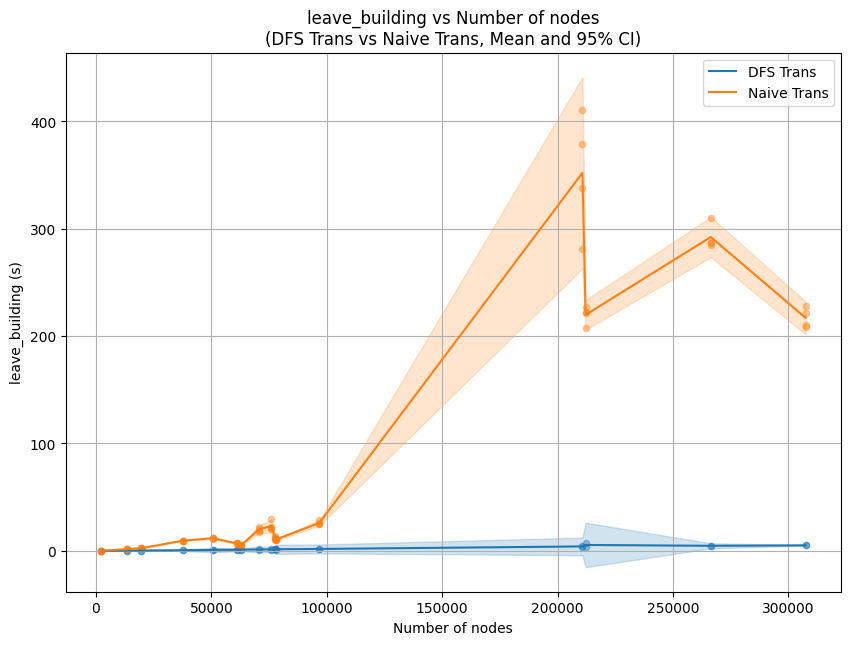

In [11]:
# Load both CSV files
df1 = pd.read_csv("experiment_results_dfs_trans.csv")
df2 = pd.read_csv("experiment_results_naive_trans.csv")

# Convert columns to numeric
for df in [df1, df2]:
    df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
    df["leave_building"] = pd.to_numeric(df["leave_building"], errors="coerce")

def plot_leave_building(df, label, color):
    means = df.groupby("Number of nodes")["leave_building"].mean()
    counts = df.groupby("Number of nodes")["leave_building"].count()
    sems = df.groupby("Number of nodes")["leave_building"].apply(sem)
    conf95 = sems * t.ppf(0.975, counts-1)
    plt.plot(means.index, means.values, label=label, color=color)
    plt.fill_between(means.index, means.values - conf95, means.values + conf95, color=color, alpha=0.2)
    plt.scatter(df["Number of nodes"], df["leave_building"], color=color, alpha=0.4, s=20)

plt.figure(figsize=(10, 7))
plot_leave_building(df1, "DFS Trans", "tab:blue")
plot_leave_building(df2, "Naive Trans", "tab:orange")

plt.xlabel("Number of nodes")
plt.ylabel("leave_building (s)")
plt.title("leave_building vs Number of nodes\n(DFS Trans vs Naive Trans, Mean and 95% CI)")
plt.grid(True)
plt.legend()
plt.show()

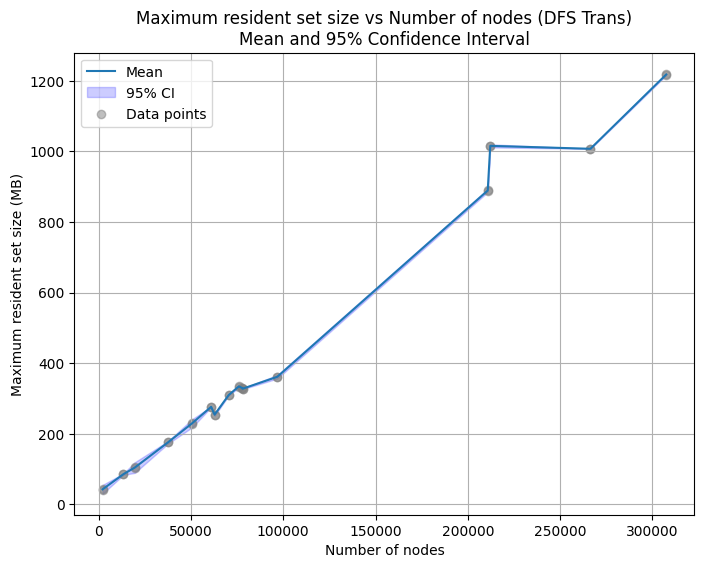

In [12]:
# Load CSV file
df = pd.read_csv("experiment_results_dfs_trans.csv")

# Convert columns to numeric
df["Number of nodes"] = pd.to_numeric(df["Number of nodes"], errors="coerce")
df["Maximum resident set size (kbytes)"] = pd.to_numeric(df["Maximum resident set size (kbytes)"], errors="coerce")

# Sort by Number of nodes
df = df.sort_values("Number of nodes")

# Group by Number of nodes and calculate mean and 95% CI
means = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].mean() / 1024  # MB
counts = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].count()
sems = df.groupby("Number of nodes")["Maximum resident set size (kbytes)"].apply(sem)
conf95 = sems * t.ppf(0.975, counts-1) / 1024  # MB

x = means.index
y = means.values

plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Mean")
plt.fill_between(x, y - conf95, y + conf95, color="b", alpha=0.2, label="95% CI")
plt.scatter(df["Number of nodes"], df["Maximum resident set size (kbytes)"] / 1024, color="gray", alpha=0.5, label="Data points")

plt.xlabel("Number of nodes")
plt.ylabel("Maximum resident set size (MB)")
plt.title("Maximum resident set size vs Number of nodes (DFS Trans)\nMean and 95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

# All reactions

/tmp/ipykernel_425641/1544840197.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


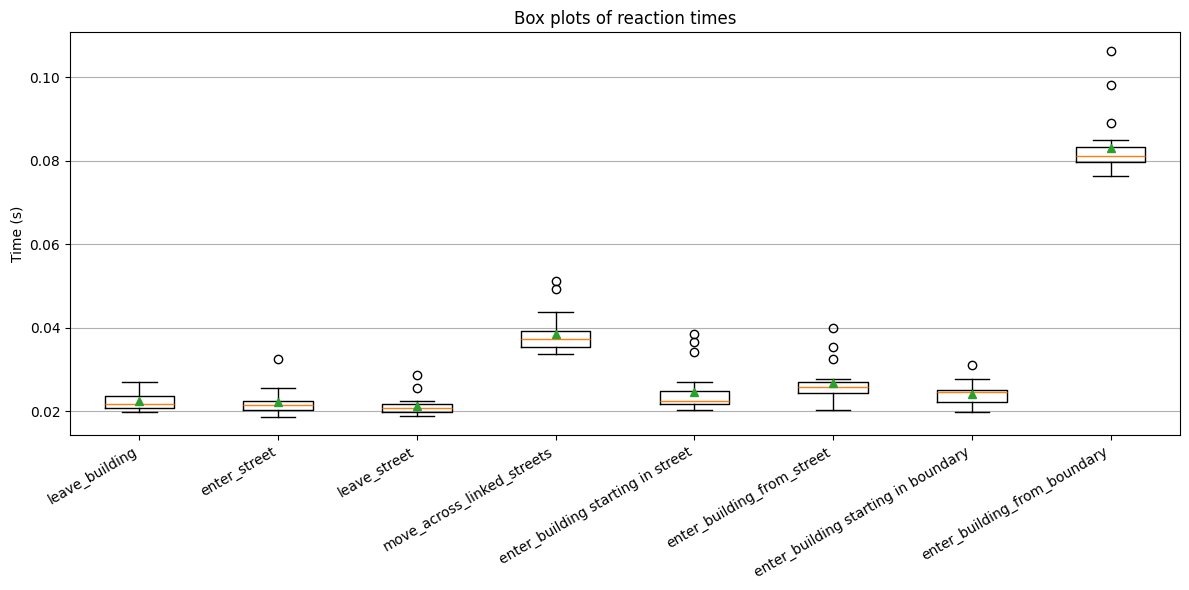

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("experiment_results_reactions_Dover.csv")

# List of columns to plot
columns = [
    "leave_building",
    "enter_street",
    "leave_street",
    "move_across_linked_streets",
    "enter_building starting in street",
    "enter_building_from_street",
    "enter_building starting in boundary",
    "enter_building_from_boundary",
]

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(12, 6))
plt.boxplot(data, labels=labels, showmeans=True)
plt.ylabel("Time (s)")
plt.title("Box plots of reaction times")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

/tmp/ipykernel_425641/1883178849.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True, vert=False)


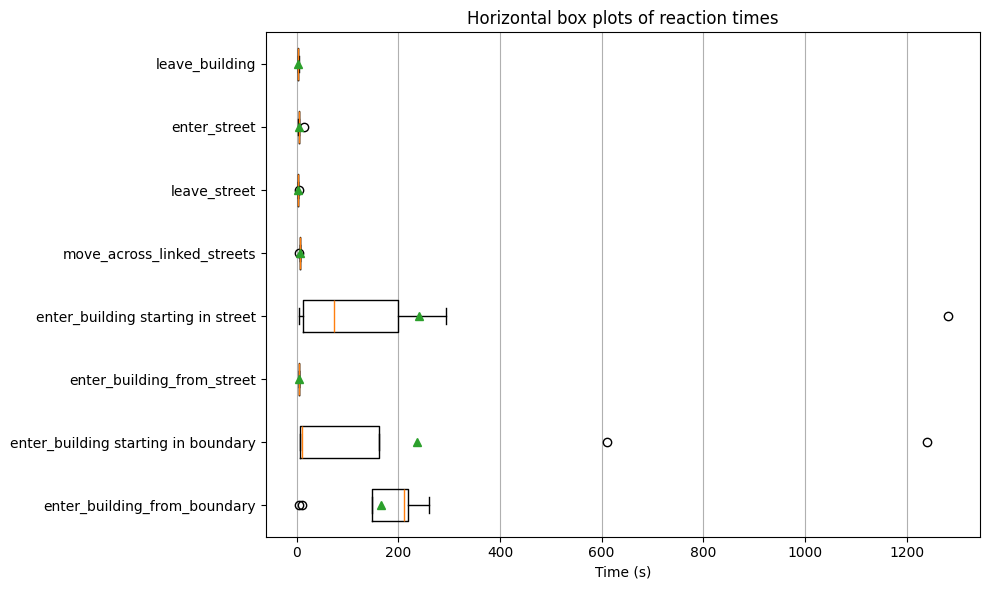

In [14]:
# Load CSV file
df = pd.read_csv("experiment_results_reactions.csv")

# List of columns to plot
columns = [
    "leave_building",
    "enter_street",
    "leave_street",
    "move_across_linked_streets",
    "enter_building starting in street",
    "enter_building_from_street",
    "enter_building starting in boundary",
    "enter_building_from_boundary",
]
columns.reverse()

# Convert columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with all NaN values
data = [df[col].dropna() for col in columns if not df[col].dropna().empty]
labels = [col for col in columns if not df[col].dropna().empty]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, showmeans=True, vert=False)
plt.xlabel("Time (s)")
plt.title("Horizontal box plots of reaction times")
# plt.yticks(rotation=30, ha="right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()